# Data science for business project
This project is made by 
- Drago Emanuele
- Lambrughi Achille

The aim of this project is to retrive, clean, analyze and develop a machine learning model starting from some given dataset.

The dataset considered are available at the following link:
- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-attivati/qbau-cyuc


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
from pathlib import PurePath
from datetime import datetime, timedelta

In [2]:
rap_lavoro_attivati = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_attivati.csv'),parse_dates=['DATA'])
print([rap_lavoro_attivati.info()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   ITALIANO                   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 657.8+ MB
[None]


In [3]:
def series_to_set(column, source_df):
    SET = set()
    for elem in source_df[column]:
        SET.add(elem)
    return SET

test_dataset = series_to_set('MODALITALAVORO', rap_lavoro_attivati)
test_dataset

{'NON DEFINITO',
 'TEMPO PARZIALE MISTO',
 'TEMPO PARZIALE ORIZZONTALE',
 'TEMPO PARZIALE VERTICALE',
 'TEMPO PIENO',
 nan}

# Dataset analysis
In this section will be analyzed the content of the datasets. The first group of datasets contain work relations started\ended\changed\extended. Calling the `info()` method is possible to see that all dataset share the same columns that are:
- DATA: date of the contract
- GENERE: sex of teh person
- ETA: age of the person
- SETTOREECONOMICODETTAGLIO: category of work
- TITOLOSTUDIO: level of education of the person
- CONTRATTO: type of contract
- MODALITALAVORO: work mode
- PROVINCIAIMPRESA: province of the place of work?
- ITALIANO: nationality of the person

From this first look at the data is possible to see that the dataset `Rapporti_di_lavoro_attivati` is bigger than the other one and this can itroduce some sort of bias in specific type of analysis

### Changing data type
Almost all columns of the dataset are type object, in the following part we will convert every column in an appropriate type.

Starting from the column `DATA` that has been converted whilie importing the data from the csv a part for `Rapporti_di_lavoro_cessati.csv` that has not been converted and so it will be converted now.
Then all the other column except for `ETA` will be converted to strings

In [4]:
rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')

as is possible to see now all the column have a specific data type

In [5]:
rap_lavoro_attivati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     string        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  string        
 4   TITOLOSTUDIO               string        
 5   CONTRATTO                  string        
 6   MODALITALAVORO             string        
 7   PROVINCIAIMPRESA           string        
 8   ITALIANO                   string        
dtypes: datetime64[ns](1), int64(1), string(7)
memory usage: 657.8 MB


### Searching wrong and null data
Now we will look inside the data checking null or possibly wrong value, after those data will be corrected or deleted.
First off we will find out how many null value there are in each column

In [6]:
print([rap_lavoro_attivati.isnull().sum()])

[DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
ITALIANO                          0
dtype: int64]


From this first look is possible to see that a big part of value is missing from the column `MODALITALAVORO` of the dataset `Rapporti_di_lavoro_attivati` these value needs to be replaced while the other could be simply deleted because they represent a small part of the dataset.

But before proceding now will be checked the actual value of some columnn to see if there are some non plausible data.
Starting from the column `DATA`

In [7]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count                          9579794
mean     2015-08-22 08:39:17.195402496
min                1973-02-01 00:00:00
25%                2012-06-07 00:00:00
50%                2015-10-08 00:00:00
75%                2018-09-07 00:00:00
max                2201-06-09 00:00:00
Name: DATA, dtype: object

In [8]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] < np.datetime64('2022-02-20')]

In [9]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count                          9579793
mean     2015-08-22 08:29:05.161381888
min                1973-02-01 00:00:00
25%                2012-06-07 00:00:00
50%                2015-10-08 00:00:00
75%                2018-09-07 00:00:00
max                2021-10-06 00:00:00
Name: DATA, dtype: object

In [10]:
rap_lavoro_attivati['DATA'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 0         2020-09-05
1         2019-12-07
2         2013-05-06
3         2010-12-03
4         2021-06-04
             ...    
9579789   2020-01-03
9579790   2010-06-09
9579791   2021-06-11
9579792   2010-02-02
9579793   2012-05-07
Name: DATA, Length: 9579793, dtype: datetime64[ns]>

In [11]:
rap_lavoro_attivati = rap_lavoro_attivati[(rap_lavoro_attivati.DATA > '2017') & (rap_lavoro_attivati.DATA < '2020')]

In [12]:
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019-12-07,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018-04-03,F,56,Confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019-09-05,F,34,Istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
21,2017-07-12,M,34,Rifugi di montagna,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018-05-07,M,54,Allevamento di bovini e bufalini da carne,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO


In [13]:
rap_lavoro_attivati.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620014 entries, 1 to 9579788
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     string        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  string        
 4   TITOLOSTUDIO               string        
 5   CONTRATTO                  string        
 6   MODALITALAVORO             string        
 7   PROVINCIAIMPRESA           string        
 8   ITALIANO                   string        
dtypes: datetime64[ns](1), int64(1), string(7)
memory usage: 199.9 MB


In [14]:
settore_economico = series_to_set('SETTOREECONOMICODETTAGLIO', rap_lavoro_attivati)
len(settore_economico)

1196

Since the `SETTOREECONOMICODETTAGLIO` column has `1125` different values belonging to it, it cannot be easily exploited to analyze data (e.g. dividing them into categories). Furthermore, there are `2888` null values in this column that can make the analysis of this feature even tougher. Considering this two facts, we can derive that dropping the whole column is more convenient than keeping it, since it introduce noise. 

In the `rap_lavoro_attivati` there are a lot of null values for the column `MODALITALAVORO`, removing the rows would reduce the set of data we are analysing. Hence, we'd rather prefer to fill those null values with a suitable values. 

In [15]:
mod_lavoro = series_to_set('MODALITALAVORO', rap_lavoro_attivati)
mod_lavoro

{'NON DEFINITO',
 'TEMPO PARZIALE MISTO',
 'TEMPO PARZIALE ORIZZONTALE',
 'TEMPO PARZIALE VERTICALE',
 'TEMPO PIENO'}

In [16]:
settori_eco = rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].fillna('')
sett_occur = dict()
settori_eco = list(settori_eco)
settori = set(settori_eco)
for settore in settori:
    sett_occur[settore] = settori_eco.count(settore)

In [17]:
common = {k: v for k, v in reversed(sorted(sett_occur.items(), key=lambda item: item[1]))}
common = list(common)[:50]

In [18]:
common[:5]

['Ristorazione con somministrazione',
 'Alberghi',
 'Attività di produzione cinematografica, di video e di programmi televisivi',
 'Pulizia generale (non specializzata) di edifici',
 'Attività di famiglie e convivenze come datori di lavoro per personale domestico']

In [19]:
rap_lavoro_attivati = rap_lavoro_attivati[
    rap_lavoro_attivati.SETTOREECONOMICODETTAGLIO.isin(common)]
rap_lavoro_attivati

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
12,2019-09-05,F,34,Istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
26,2017-12-06,F,26,Bar e altri esercizi simili senza cucina,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA
28,2019-08-04,F,45,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA
42,2018-10-12,F,24,Ristorazione con somministrazione,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA
51,2019-09-09,M,47,Fabbricazione di strutture metalliche e parti ...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,LECCO,ITALIA
...,...,...,...,...,...,...,...,...,...
9579758,2018-03-09,M,29,Ristorazione con somministrazione,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,MONZA E BRIANZA,ITALIA
9579764,2018-03-01,F,41,Bar e altri esercizi simili senza cucina,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA
9579766,2017-03-02,M,45,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MONZA E BRIANZA,EGITTO
9579777,2018-04-05,F,35,Mense,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA


In [20]:
bins = np.arange(14, 68, 3).tolist()
bins

[14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65]

In [21]:
rap_lavoro_attivati['agerange'] = pd.cut(rap_lavoro_attivati['ETA'], bins)
rap_lavoro_attivati

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,agerange
12,2019-09-05,F,34,Istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(32, 35]"
26,2017-12-06,F,26,Bar e altri esercizi simili senza cucina,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA,"(23, 26]"
28,2019-08-04,F,45,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,"(44, 47]"
42,2018-10-12,F,24,Ristorazione con somministrazione,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA,"(23, 26]"
51,2019-09-09,M,47,Fabbricazione di strutture metalliche e parti ...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,LECCO,ITALIA,"(44, 47]"
...,...,...,...,...,...,...,...,...,...,...
9579758,2018-03-09,M,29,Ristorazione con somministrazione,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,MONZA E BRIANZA,ITALIA,"(26, 29]"
9579764,2018-03-01,F,41,Bar e altri esercizi simili senza cucina,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(38, 41]"
9579766,2017-03-02,M,45,Costruzione di edifici residenziali e non resi...,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MONZA E BRIANZA,EGITTO,"(44, 47]"
9579777,2018-04-05,F,35,Mense,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(32, 35]"


The value `NON DEFINITO` can be used to fill the na, since that won't introduce much bias, differently from the other available values. 

In [22]:
def clean(df):
    df['MODALITALAVORO'] = df['MODALITALAVORO'].fillna('NON DEFINITO')
    df.dropna(axis = 0, inplace = True)
    

clean(rap_lavoro_attivati)
rap_lavoro_attivati.isnull().sum()

DATA                         0
GENERE                       0
ETA                          0
SETTOREECONOMICODETTAGLIO    0
TITOLOSTUDIO                 0
CONTRATTO                    0
MODALITALAVORO               0
PROVINCIAIMPRESA             0
ITALIANO                     0
agerange                     0
dtype: int64

#### Working on column `DATA`
In this section we will analyze in more detail the column `DATA` and adjust the data accordingly.
The first step is to group the column by year and count how many contract are activated per year

In [23]:
print(rap_lavoro_attivati.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count())

DATA
2017-12-31    495618
2018-12-31    527916
2019-12-31    526889
Freq: A-DEC, Name: DATA, dtype: int64


as is possible to see meany of the value have date between 2009 and 2022, so to have a more significant set of data we will remove all the row with date previous to 2009

In [24]:
rap_lavoro_attivati = rap_lavoro_attivati[(rap_lavoro_attivati["DATA"] >= '2009')]
attivatiTemp = rap_lavoro_attivati[(rap_lavoro_attivati["DATA"] >= '2009')]

In [25]:
print(attivatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count())

DATA
2017-12-31    495618
2018-12-31    527916
2019-12-31    526889
Freq: A-DEC, Name: DATA, dtype: int64


With this we can see how many contract have been activated in the last few years in the Lombardy region. But before that we apply the same changes to the other datast and after that we can compare the result

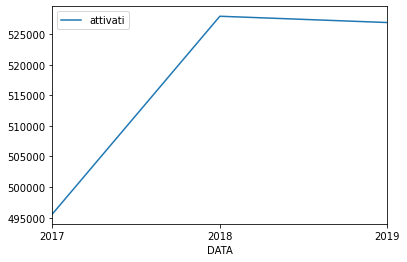

In [26]:
attivatiTemp.groupby(pd.Grouper(key='DATA', freq='Y'))['DATA'].count().plot(label="attivati")
plt.legend()
plt.show()

is possible to see that *attivati* and *cessati*  have a simila behavior but in a different scale while *trasformati* and *prorogati* differs from the previous but have some similarity between them.

(-1.1055715593848623,
 1.1107916016555455,
 -1.1082334257017286,
 1.1003920678905585)

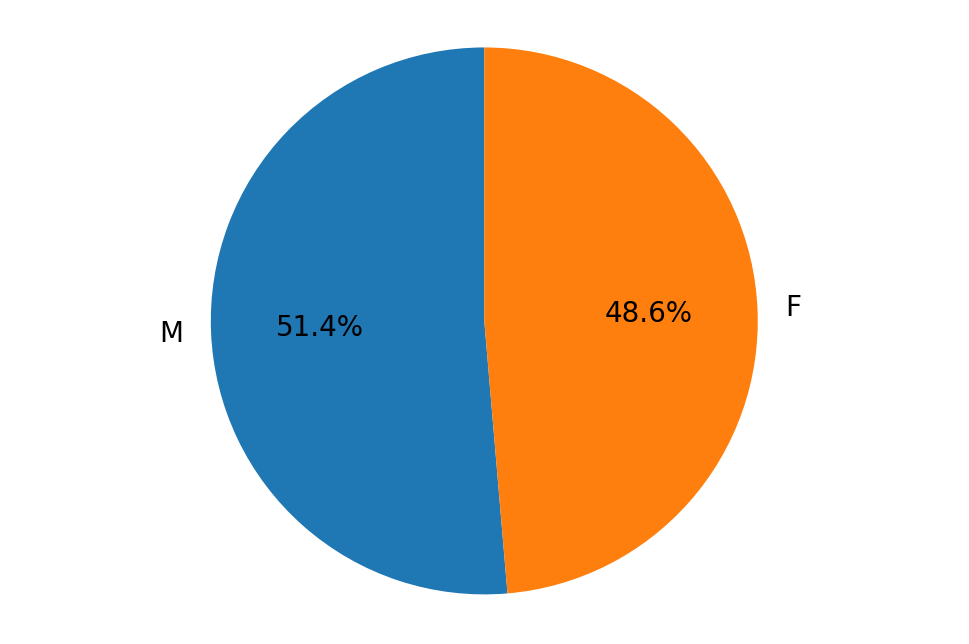

In [27]:
m_to_f_rationA = rap_lavoro_attivati.GENERE.value_counts()

xaxisA = m_to_f_rationA.index
valueA = m_to_f_rationA.values

fig1, axis = plt.subplots(1)
fig1.dpi = 200

#Attivati male to female Graph
axis.pie(valueA, labels=xaxisA, autopct='%1.1f%%', startangle=90)
axis.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


from these graphs we can say that probably there are more male than female in the popoulation

## Introducing another dataset
This dataset contain the level of education for age referred to the region lombardy from the year 2018 to 2020.The educational level  are coded in teh following way:
- NED = nessun titolo di studio
- IL =  analfabeti
- LBNA = analfabeti privi di titolo di studio
- PSE = licenza di scuola elementare
- LSE = licenza media o avviamento professionale (conseguito non oltre l'anno 1965)/ Diploma di istruzione secondaria di I grado
- USE_IF = Diploma di istruzione secondaria di II grado o di qualifica professionale (corso di 3-4 anni) compresi IFTS
- BL = Diploma tecnico superiore ITS o titolo di studio terziario di primo livello
- ML_RDD = titolo di studio terziario di secondo livello e dottorato di ricerca
- ML = Titolo di studio terziario di secondo livello
- RDD = Dottorato di ricerca/diploma accademico di formazione alla ricerca
- ALL = totale

In [28]:
grado_istruzione_age  = pd.read_csv(PurePath('dataset', 'Grado_istruzione_per_età_Lombardia_IT1,DF_DCSS_ISTR_LAV_PEN_2_REG.csv'),low_memory=False)
grado_istruzione_age.head()

,DATAFLOW,FREQ,REF_AREA,INDICATOR,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE,OBS_STATUS,NOTE_DS,NOTE_REF_AREA,NOTE_INDICATOR,NOTE_GENDER,NOTE_AGE_NOCLASS,NOTE_CITIZENSHIP,NOTE_EDU_ATTAIN,NOTE_CUR_ACT_STAT,NOTE_LOC_DEST,NOTE_REAS_COMMUTING
0,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2018,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
1,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2019,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
2,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2020,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
3,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2018,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN
4,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN


there are some column with null value that can be deleted

In [29]:
grado_istruzione_age = grado_istruzione_age[['REF_AREA', 'GENDER', 'AGE_NOCLASS', 'EDU_ATTAIN', 'TIME_PERIOD', 'OBS_VALUE']]

In [30]:
grado_istruzione_age ['AGE_NOCLASS'].value_counts()

Y_GE9     145979
Y25-49     92357
Y50-64     91652
Y_GE65     90061
Y9-24      88907
Name: AGE_NOCLASS, dtype: int64

those value represet age range in specific:
- Y_GE9: all people with age greater than 9, in this case all the people in the dataset
- Y25-49: people with an age between 25 and 49
- Y50-64: people with an age between 50 and 64
- Y_GE65: people with more than 65 years
- Y9-24: people with an age between 9 and 24

In the following part we will add a column with the saem age range of the dataset *Grado_istruzione_per_età_Lombardia*

In [31]:
"""bins = [0,25, 50, 65, 200]
labels = ['Y9-24', 'Y25-49', 'Y50-64','Y_GE65' ]
rap_lavoro_attivati['agerange'] = pd.cut(rap_lavoro_attivati['ETA'], bins, labels = labels,include_lowest = True)
rap_lavoro_attivati"""

"bins = [0,25, 50, 65, 200]\nlabels = ['Y9-24', 'Y25-49', 'Y50-64','Y_GE65' ]\nrap_lavoro_attivati['agerange'] = pd.cut(rap_lavoro_attivati['ETA'], bins, labels = labels,include_lowest = True)\nrap_lavoro_attivati"

because in the dataset *rapporti di lavoro* the minimum age is 16 while in *Grado_istruzione_per_età_Lombardia* is 9 we will delete all the illiterate and the people with only elementary school license with the age between 9 and 24  from the dataset, we have choose to do so because the majority of people in that age range with only elementary school license are the one under 16 year

In [32]:
grado_istruzione_age = grado_istruzione_age [~((grado_istruzione_age ['EDU_ATTAIN']== 'IL')|(grado_istruzione_age ['EDU_ATTAIN']== 'LBNA')|((grado_istruzione_age ['EDU_ATTAIN']== 'PSE')&(grado_istruzione_age ['AGE_NOCLASS']== 'Y9_24')))]
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
0,012001,F,Y_GE65,ALL,2018,54
1,012001,F,Y_GE65,ALL,2019,59
2,012001,F,Y_GE65,ALL,2020,63
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
...,...,...,...,...,...,...
508951,ITC4B,T,Y9-24,PSE,2019,12282
508952,ITC4B,T,Y9-24,PSE,2020,12409
508953,ITC4B,T,Y9-24,USE_IF,2018,16491
508954,ITC4B,T,Y9-24,USE_IF,2019,16647


In [33]:
print(rap_lavoro_attivati['TITOLOSTUDIO'].head())
grado_istruzione_age['EDU_ATTAIN'].head()

12                 LAUREA - Vecchio o nuovo ordinamento
26                              NESSUN TITOLO DI STUDIO
28                              NESSUN TITOLO DI STUDIO
42    DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...
51                              NESSUN TITOLO DI STUDIO
Name: TITOLOSTUDIO, dtype: string


0    ALL
1    ALL
2    ALL
3     BL
4     BL
Name: EDU_ATTAIN, dtype: object

The series `TITOLO_STUDIO` and `EDU_ATTAIN` don't match easily, but we can map the values of `EDU_ATTAIN` into `TITOLO_STUDIO`.

In [34]:
print(series_to_set('TITOLOSTUDIO', rap_lavoro_attivati))
print(series_to_set('EDU_ATTAIN', grado_istruzione_age))

{'DIPLOMA UNIVERSITARIO', 'LAUREA - Vecchio o nuovo ordinamento', "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA", 'LICENZA ELEMENTARE', 'DIPLOMA DI SPECIALIZZAZIONE', 'LICENZA MEDIA', 'TITOLO DI STUDIO POST-LAUREA', 'TITOLO DI DOTTORE DI RICERCA', 'NESSUN TITOLO DI STUDIO', 'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', 'MASTER UNIVERSITARIO DI PRIMO LIVELLO', "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()"}
{'ALL', 'ML', 'PSE', 'USE_IF', 'LSE', 'BL', 'RDD', 'NED', 'ML_RDD'}


In [35]:
grado_istruzione_age.loc[(grado_istruzione_age.EDU_ATTAIN.isin(['ML_RDD'])) & ~(grado_istruzione_age.AGE_NOCLASS == 'Y_GE9')]

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
9,012001,F,Y_GE65,ML_RDD,2018,4
10,012001,F,Y_GE65,ML_RDD,2019,4
11,012001,F,Y_GE65,ML_RDD,2020,3
58,012001,F,Y25-49,ML_RDD,2018,16
59,012001,F,Y25-49,ML_RDD,2019,15
...,...,...,...,...,...,...
508924,ITC4B,T,Y50-64,ML_RDD,2019,7841
508925,ITC4B,T,Y50-64,ML_RDD,2020,8141
508944,ITC4B,T,Y9-24,ML_RDD,2018,302
508945,ITC4B,T,Y9-24,ML_RDD,2019,186


In [36]:
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age['TIME_PERIOD'] != 2020]
grado_istruzione_age = grado_istruzione_age[~grado_istruzione_age.EDU_ATTAIN.isin(['ALL', 'ML', 'RDD'])]
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.AGE_NOCLASS != 'Y_GE9']
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.GENDER != 'T']
grado_istruzione_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
6,012001,F,Y_GE65,LSE,2018,11
7,012001,F,Y_GE65,LSE,2019,19
9,012001,F,Y_GE65,ML_RDD,2018,4


In [37]:
edu_map = {
    'IL': 'NESSUN TITOLO DI STUDIO',
    'NED': 'NESSUN TITOLO DI STUDIO',
    'LBNA': 'NESSUN TITOLO DI STUDIO',
    'PSE': 'LICENZA ELEMENTARE',
    'LSE': 'LICENZA MEDIA',
    'USE_IF': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    'BL': 'LAUREA',
    'ML_RDD': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'LAUREA - Vecchio o nuovo ordinamento': 'LAUREA',
    'DIPLOMA DI SPECIALIZZAZIONE': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA UNIVERSITARIO': 'LAUREA'   
}


In [38]:
def mapping(series): 
    series = series.apply(lambda x: edu_map.get(x) if edu_map.get(x) != None else x)
    return series

rap_lavoro_attivati['TITOLOSTUDIO'] = mapping(rap_lavoro_attivati['TITOLOSTUDIO'])

grado_istruzione_age['EDU_ATTAIN'] = mapping(grado_istruzione_age['EDU_ATTAIN'])

grado_istruzione_age['EDU_ATTAIN']


3                                                    LAUREA
4                                                    LAUREA
6                                             LICENZA MEDIA
7                                             LICENZA MEDIA
9         TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...
                                ...                        
508831                              NESSUN TITOLO DI STUDIO
508833                                   LICENZA ELEMENTARE
508834                                   LICENZA ELEMENTARE
508836           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
508837           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
Name: EDU_ATTAIN, Length: 135309, dtype: object

In [39]:
rap_lavoro_attivati['TITOLOSTUDIO']

12                                             LAUREA
26                            NESSUN TITOLO DI STUDIO
28                            NESSUN TITOLO DI STUDIO
42         DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
51                            NESSUN TITOLO DI STUDIO
                              ...                    
9579758                       NESSUN TITOLO DI STUDIO
9579764    DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
9579766                       NESSUN TITOLO DI STUDIO
9579777                                 LICENZA MEDIA
9579788                                 LICENZA MEDIA
Name: TITOLOSTUDIO, Length: 1550423, dtype: object

In the next section we'll see a graph comparing the number of contract activated and the tota number of population in 2018

ValueError: shape mismatch: objects cannot be broadcast to a single shape

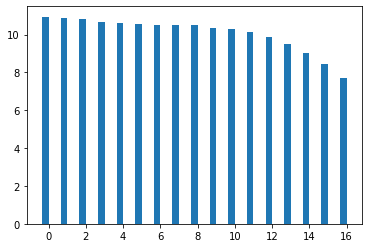

In [40]:
import datetime as dt

activate2018 = rap_lavoro_attivati[rap_lavoro_attivati['DATA'].dt.year == 2018]
istr2018 = grado_istruzione_age[(grado_istruzione_age['TIME_PERIOD']== 2018)]
total = istr2018.groupby(['AGE_NOCLASS']).sum()


testAge = activate2018['agerange'].value_counts()

labels = testAge.index
newContract = np.log(testAge.values)
totalPopulation = np.log(total['OBS_VALUE'].values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, newContract, width, label='New Contract')
rects2 = ax.bar(x + width/2, totalPopulation, width, label='Total Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log number')
ax.set_title('number by attivati vs total number')
ax.set_xticks(x)
ax.set_xticklabels(labels=labels,rotation=45,
    horizontalalignment='right');
ax.legend()



fig.tight_layout()

plt.show()

In [41]:
city_codes = pd.read_excel(PurePath('dataset', 'Elenco-comuni-italiani.xls'))
city_codes = city_codes[['Codice Comune formato alfanumerico', 
                        'Denominazione in italiano',
                        'Denominazione Regione',
                        'Provincia',
                        'Codice NUTS3 2021',
                        'Codice NUTS2 2021 (3) '
                        ]]
city_codes = city_codes[city_codes['Denominazione Regione'] == 'Lombardia']
city_codes = city_codes.set_index('Codice Comune formato alfanumerico')
city_codes.loc[1] = ['','','Milano','ITC45','']   #The code in the dataset does not match with the code of Milano, 
                                                  #manually added
city_codes.head()

,Denominazione in italiano,Denominazione Regione,Provincia,Codice NUTS3 2021,Codice NUTS2 2021 (3)
Codice Comune formato alfanumerico,,,,,
12001,Agra,Lombardia,Varese,ITC41,ITC4
12002,Albizzate,Lombardia,Varese,ITC41,ITC4
12003,Angera,Lombardia,Varese,ITC41,ITC4
12004,Arcisate,Lombardia,Varese,ITC41,ITC4
12005,Arsago Seprio,Lombardia,Varese,ITC41,ITC4


In [42]:
def get_provincia_by_code(code):
    return city_codes[city_codes['Codice NUTS3 2021'] == code]['Provincia'].iloc[0]
                    

In [43]:
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.REF_AREA.isin(city_codes['Codice NUTS3 2021'])]

In [44]:
grado_istruzione_age['REF_AREA'] = grado_istruzione_age['REF_AREA'].apply(lambda x: get_provincia_by_code(x)) 
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
505098,Varese,F,Y_GE65,LAUREA,2018,713
505099,Varese,F,Y_GE65,LAUREA,2019,740
505101,Varese,F,Y_GE65,LICENZA MEDIA,2018,26254
505102,Varese,F,Y_GE65,LICENZA MEDIA,2019,27471
505104,Varese,F,Y_GE65,TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...,2018,4324
...,...,...,...,...,...,...
508831,Mantova,M,Y9-24,NESSUN TITOLO DI STUDIO,2019,4294
508833,Mantova,M,Y9-24,LICENZA ELEMENTARE,2018,6457
508834,Mantova,M,Y9-24,LICENZA ELEMENTARE,2019,6478
508836,Mantova,M,Y9-24,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,2018,8556


In [45]:
grado_istruzione_age[grado_istruzione_age.REF_AREA == 'Milano'].groupby(['REF_AREA', 'TIME_PERIOD', 'GENDER', 'EDU_ATTAIN', 'AGE_NOCLASS']).sum().head(60)

OBS_VALUE
REF_AREA TIME_PERIOD GENDER EDU_ATTAIN                                         AGE_NOCLASS           
Milano   2018        F      DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE         Y25-49          233709
                                                                               Y50-64          168626
                                                                               Y9-24            63168
                                                                               Y_GE65          104197
                            LAUREA                                             Y25-49           51061
                                                                               Y50-64            9833
                                                                               Y9-24             8967
                                                                               Y_GE65            3910
                            LICENZA ELEMENTARE                                 Y25-49            7233
                                                                               Y50-64           21561
                                                                               Y9-24            46433
                                                                               Y_GE65          163230
                            LICENZA MEDIA                                      Y25-49           86094
                                                                               Y50-64           91406
                                                                               Y9-24            79702
                                                                               Y_GE65          103352
                            NESSUN TITOLO DI STUDIO                            Y25-49            6880
                                                                               Y50-64            5384
                                                                               Y9-24            31100
                                                                               Y_GE65           23138
                            TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O... Y25-49          152014
                                                                               Y50-64           58013
                                                                               Y9-24             1643
                                                                               Y_GE65           30184
                     M      DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE         Y25-49          242692
                                                                               Y50-64          143466
                                                                               Y9-24            67853
                                                                               Y_GE65           95673
                            LAUREA                                             Y25-49           39849
                                                                               Y50-64            5491
                                                                               Y9-24             7584
                                                                               Y_GE65            1639
                            LICENZA ELEMENTARE                                 Y25-49            9894
                                                                               Y50-64           18283
                                                                               Y9-24            50984
                                                                               Y_GE65           85049
                            LICENZA MEDIA                                      Y25-49          124160
                                                                               Y50-64          106011
            

In [46]:
series_to_set('REF_AREA', grado_istruzione_age)

{'Bergamo',
 'Brescia',
 'Como',
 'Cremona',
 'Lecco',
 'Lodi',
 'Mantova',
 'Milano',
 'Pavia',
 'Sondrio',
 'Varese'}

# Building a machine learning model


In [47]:
import pandas as pd
import numpy as np

import matplotlib as mtl
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

creating a dataset for the machin learning

In [52]:
testnum = rap_lavoro_attivati[['GENERE', 'ETA', 'agerange', 'TITOLOSTUDIO', 'CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA']].copy(deep=True)
testnum['RANKGENERE'] = testnum['GENERE'].rank(method='dense', ascending=False).astype('Int64')
testnum['RANKTITOLOSTUDIO'] = testnum['TITOLOSTUDIO'].rank(method='dense', ascending=False).astype('Int64')
testnum['RANKCONTRATTO'] = testnum['CONTRATTO'].rank(method='dense', ascending=False).astype('Int64')
testnum['RANKMODALITALAVORO'] = testnum['MODALITALAVORO'].rank(method='dense', ascending=False).astype('Int64')
testnum['RANKPROVINCIAIMPRESA'] = testnum['PROVINCIAIMPRESA'].rank(method='dense', ascending=False).astype('Int64')
testnum['RANKagerange'] = testnum['agerange'].rank(method='dense', ascending=False).astype('float')
testnum

,GENERE,ETA,agerange,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,RANKGENERE,RANKTITOLOSTUDIO,RANKCONTRATTO,RANKMODALITALAVORO,RANKPROVINCIAIMPRESA,RANKagerange
12,F,34,"(32, 35]",LAUREA,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,2,7,8,3,12,11
26,F,26,"(23, 26]",NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,2,4,3,5,12,14
28,F,45,"(44, 47]",NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,2,4,5,1,12,7
42,F,24,"(23, 26]",DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,2,8,3,5,12,14
51,M,47,"(44, 47]",NESSUN TITOLO DI STUDIO,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,LECCO,1,4,8,1,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9579758,M,29,"(26, 29]",NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,MONZA E BRIANZA,1,4,3,5,4,13
9579764,F,41,"(38, 41]",DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,2,8,8,3,4,9
9579766,M,45,"(44, 47]",NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MONZA E BRIANZA,1,4,10,1,4,7
9579777,F,35,"(32, 35]",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,2,5,10,3,4,11


In [71]:
testnum['RANKagerange'] = testnum['agerange'].rank(method='dense', ascending=False).astype('float')

In [72]:
X = testnum[['RANKGENERE', 'RANKTITOLOSTUDIO', 'RANKCONTRATTO', 'RANKMODALITALAVORO','RANKPROVINCIAIMPRESA']]
y = testnum['RANKagerange']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

training the model

In [73]:
testnum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550423 entries, 12 to 9579788
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   GENERE                1550423 non-null  string  
 1   ETA                   1550423 non-null  int64   
 2   agerange              1550423 non-null  category
 3   TITOLOSTUDIO          1550423 non-null  object  
 4   CONTRATTO             1550423 non-null  string  
 5   MODALITALAVORO        1550423 non-null  string  
 6   PROVINCIAIMPRESA      1550423 non-null  string  
 7   RANKGENERE            1550423 non-null  Int64   
 8   RANKTITOLOSTUDIO      1550423 non-null  Int64   
 9   RANKCONTRATTO         1550423 non-null  Int64   
 10  RANKMODALITALAVORO    1550423 non-null  Int64   
 11  RANKPROVINCIAIMPRESA  1550423 non-null  Int64   
 12  RANKagerange          1550423 non-null  float64 
dtypes: Int64(5), category(1), float64(1), int64(1), object(1), string(4)
me

In [79]:
mlpModel = MLPClassifier(random_state=1, max_iter=5, hidden_layer_sizes=(18,18))
mlpModel = mlpModel.fit(X_train, y_train)

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Check the model performance

In [80]:
#prediction and probability
mlp_pred = mlpModel.predict(X_test)
mlp_proba = mlpModel.predict_proba(X_test)

#Report metrix
reportMLP = classification_report(y_test, mlp_pred,output_dict= True)
accMlp = accuracy_score(y_test, mlp_pred)
print('Accuracy:')
print(accMlp)
print('\nConfusion matrix:')
confusion_matrix(y_test, mlp_pred)

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emanu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:
0.12432212091660087

Confusion matrix:


array([[    0,     0,   119,     0,   279,   312,    43,     0,     0,
           14,    35,   295,   193,  1655,   428,   245,     0],
       [    0,     0,   166,     0,   433,   481,   115,     0,     0,
           56,    63,   698,   343,  3016,   649,   344,     0],
       [    0,     0,   199,     0,   531,   642,   166,     0,     0,
           88,   126,  1012,   606,  5046,  1069,   457,     0],
       [    0,     0,   179,     0,   623,   928,   241,     0,     1,
           93,   149,  1630,   774,  7718,  1575,   652,     0],
       [    0,     0,   142,     0,   525,   899,   307,     0,     0,
          141,   193,  1971,  1011, 10244,  2038,   729,     0],
       [    0,     0,   153,     0,   548,   978,   351,     0,     2,
          149,   198,  2276,  1211, 12267,  2354,   816,     0],
       [    0,     0,   119,     0,   439,   948,   399,     0,     0,
          161,   225,  2531,  1534, 13836,  2797,   882,     0],
       [    0,     0,    96,     0,   393,   904

[(32, 35], (23, 26], (44, 47], (26, 29], (29, 32], ..., (38, 41], (41, 44], (56, 59], (59, 62], (14, 17]]
Length: 17
Categories (17, interval[int64]): [(14, 17] < (17, 20] < (20, 23] < (23, 26] ... (53, 56] < (56, 59] < (59, 62] < (62, 65]]